## 모델 등록하기
이 실습에서는 간소화를 위해 로컬 tracking 서버와 모델 레지스트리를 활용합니다. 
프로덕션에서는 원격 tracking 서버를 사용하는 것이 좋습니다.
- 출처 : https://mlflow.org/docs/latest/getting-started/registering-first-model/step1-register-model.html
- 수정사항 : 설명문을 한글로 번역

## 0단계: 패키지 설치

In [6]:
# %pip install -qU mlflow

Note: you may need to restart the kernel to use updated packages.


## 1단계: 모델 등록하기
MLflow 모델 레지스트리를 사용하려면 MLflow 모델을 추가해야 합니다.
이는 아래 명령 중 하나를 통해 지정된 모델을 등록하면 됩니다:

- `mlflow.<model_flavor>.log_model(registered_model_name=<model_name>)`: tracking 서버에 로깅하면서 모델을 등록합니다.
- `mlflow.register_model(<model_uri>, <model_name>)`: tracking 서버에 로깅한 후 모델을 등록합니다.   
    이 명령을 실행하기 전에 모델을 로깅해야 모델 URI를 얻을 수 있습니다.
  
MLflow에는 다양한 모델 종류가 있습니다.   
아래 예에서는 가장 간단한 모델 등록 방법을 보여드리기 위해 scikit-learn의 RandomForestRegressor를 활용하지만,    
[지원되는 모든 모델 flavor](https://mlflow.org/docs/latest/models.html#built-in-model-flavors)를 활용할 수 있습니다.  

아래 코드 스니펫에서는 mlflow 실행을 시작하고 랜덤 포레스트 모델을 훈련합니다.   
그런 다음 몇 가지 관련 하이퍼파라미터와 모델 평균제곱오차(MSE)를 기록하고 마지막으로 모델 자체를 기록 및 등록합니다.

In [4]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
import mlflow.sklearn

with mlflow.start_run() as run:
    X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    params = {"max_depth": 2, "random_state": 42}
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    # Log parameters and metrics using the MLflow APIs
    mlflow.log_params(params)

    y_pred = model.predict(X_test)
    mlflow.log_metrics({"mse": mean_squared_error(y_test, y_pred)})

    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="sklearn-model",
        input_example=X_train,
        registered_model_name="sk-learn-random-forest-reg-model",
    )

Successfully registered model 'sk-learn-random-forest-reg-model'.
Created version '1' of model 'sk-learn-random-forest-reg-model'.


모델을 등록하려면 mlflow.sklearn.log_model()에서 등록된 모델 이름 매개 변수를 활용하거나    
모델을 로깅한 후 mlflow.register_model()을 호출할 수 있습니다.    
일반적으로 전자가 더 간결하기 때문에 전자를 권장합니다.

모델 서명은 모델 입력과 출력에 대한 유효성 검사를 제공합니다.   
log_model()의 input_example은 자동으로 서명을 유추하여 기록합니다.    
다시 말하지만, 간결하기 때문에 이 구현을 사용하는 것이 좋습니다

## 등록된 모델 살펴보기
이제 실험을 기록하고 해당 실험 실행과 관련된 모델을 등록했으므로   
이 정보가 실제로 MLflow UI와 로컬 디렉터리에 어떻게 저장되는지 살펴봅시다.   
프로그래밍 방식으로도 이 정보를 얻을 수 있지만 설명하기 위해 MLflow UI를 사용하겠습니다.



### 1단계: mlruns 디렉토리 살펴보기
로컬 파일 시스템을 Tracking 서버 및 모델 레지스트리로 사용하고 있으므로,    
이전 단계에서 파이썬 스크립트를 실행할 때 생성된 디렉터리 구조를 관찰해 보겠습니다.
    
자세히 알아보기 전에 MLflow는 사용자의 복잡성을 줄이기 위해 설계되었으며   
이 디렉터리 구조는 단지 설명을 위한 것임을 알아두는 것이 중요합니다.   
또한, 프로덕션 사용 사례에 권장되는 원격 배포의 경우 Tracking 서버는 객체 저장소(S3, ADLS, GCS 등)에 있고    
모델 레지스트리는 관계형 데이터베이스(PostgreSQL, MySQL 등)에 있습니다

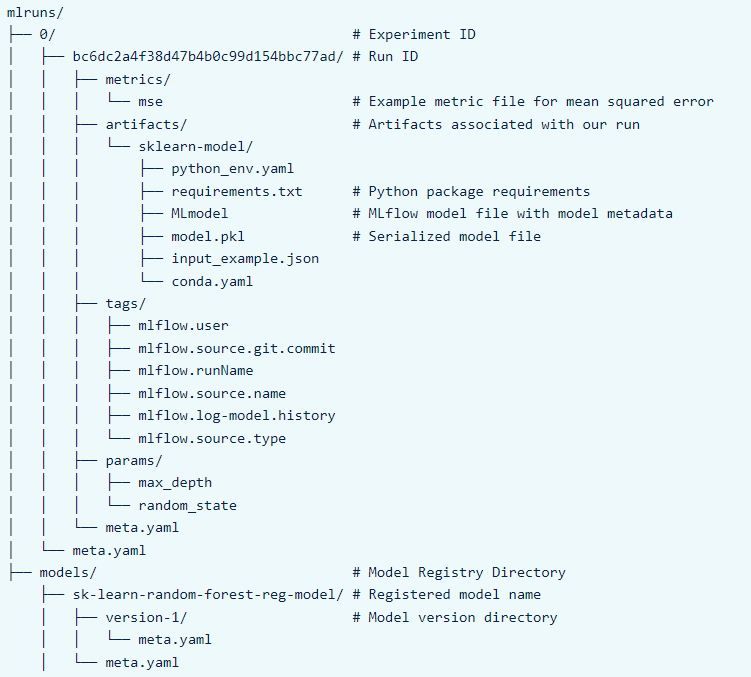

Tracking 서버는  Experiment ID와 Run ID 로 구성되며 Experiment artifacts, Parameters, Metrics를 저장하는 역할을 담당합니다.    
반면에 모델 레지스트리는 Tracking 서버에 대한 포인터와 함께 메타데이터만 저장합니다.   
    
[autologging](https://mlflow.org/docs/latest/tracking/autolog.html) 지원하는 flavor는 기본적으로 많은 추가 정보를 제공합니다.   
또한 관심 있는 모델에 대해 오토로깅을 지원하지 않더라도 명시적 로깅 호출을 통해 이 정보를 쉽게 저장할 수 있습니다.

한 가지 더 흥미로운 점은 기본적으로 모델 환경을 관리할 수 있는 세 가지 방법,   
python_env.yaml(python virtualenv), requirements.txt(PyPi requirements), conda.yaml(conda env)이 제공되는 것입니다.
    
이제 로깅되는 내용에 대해 이해했으니 MLflow UI를 사용하여 이 정보를 확인해 보겠습니다.



### 2단계: Tracking Server 시작
- mlruns 폴더와 동일한 디렉터리에서 아래 명령을 실행합니다.  
`mlflow server --host 127.0.0.1 --port 8080`

### 3단계: 트래킹 서버 보기
웹 브라우저로 http://localhost:8080에 접속하하여 MLflow UI를 볼 수 있습니다.      
models 메뉴를 클릭하여 모델 레지스트리로 이동합니다.
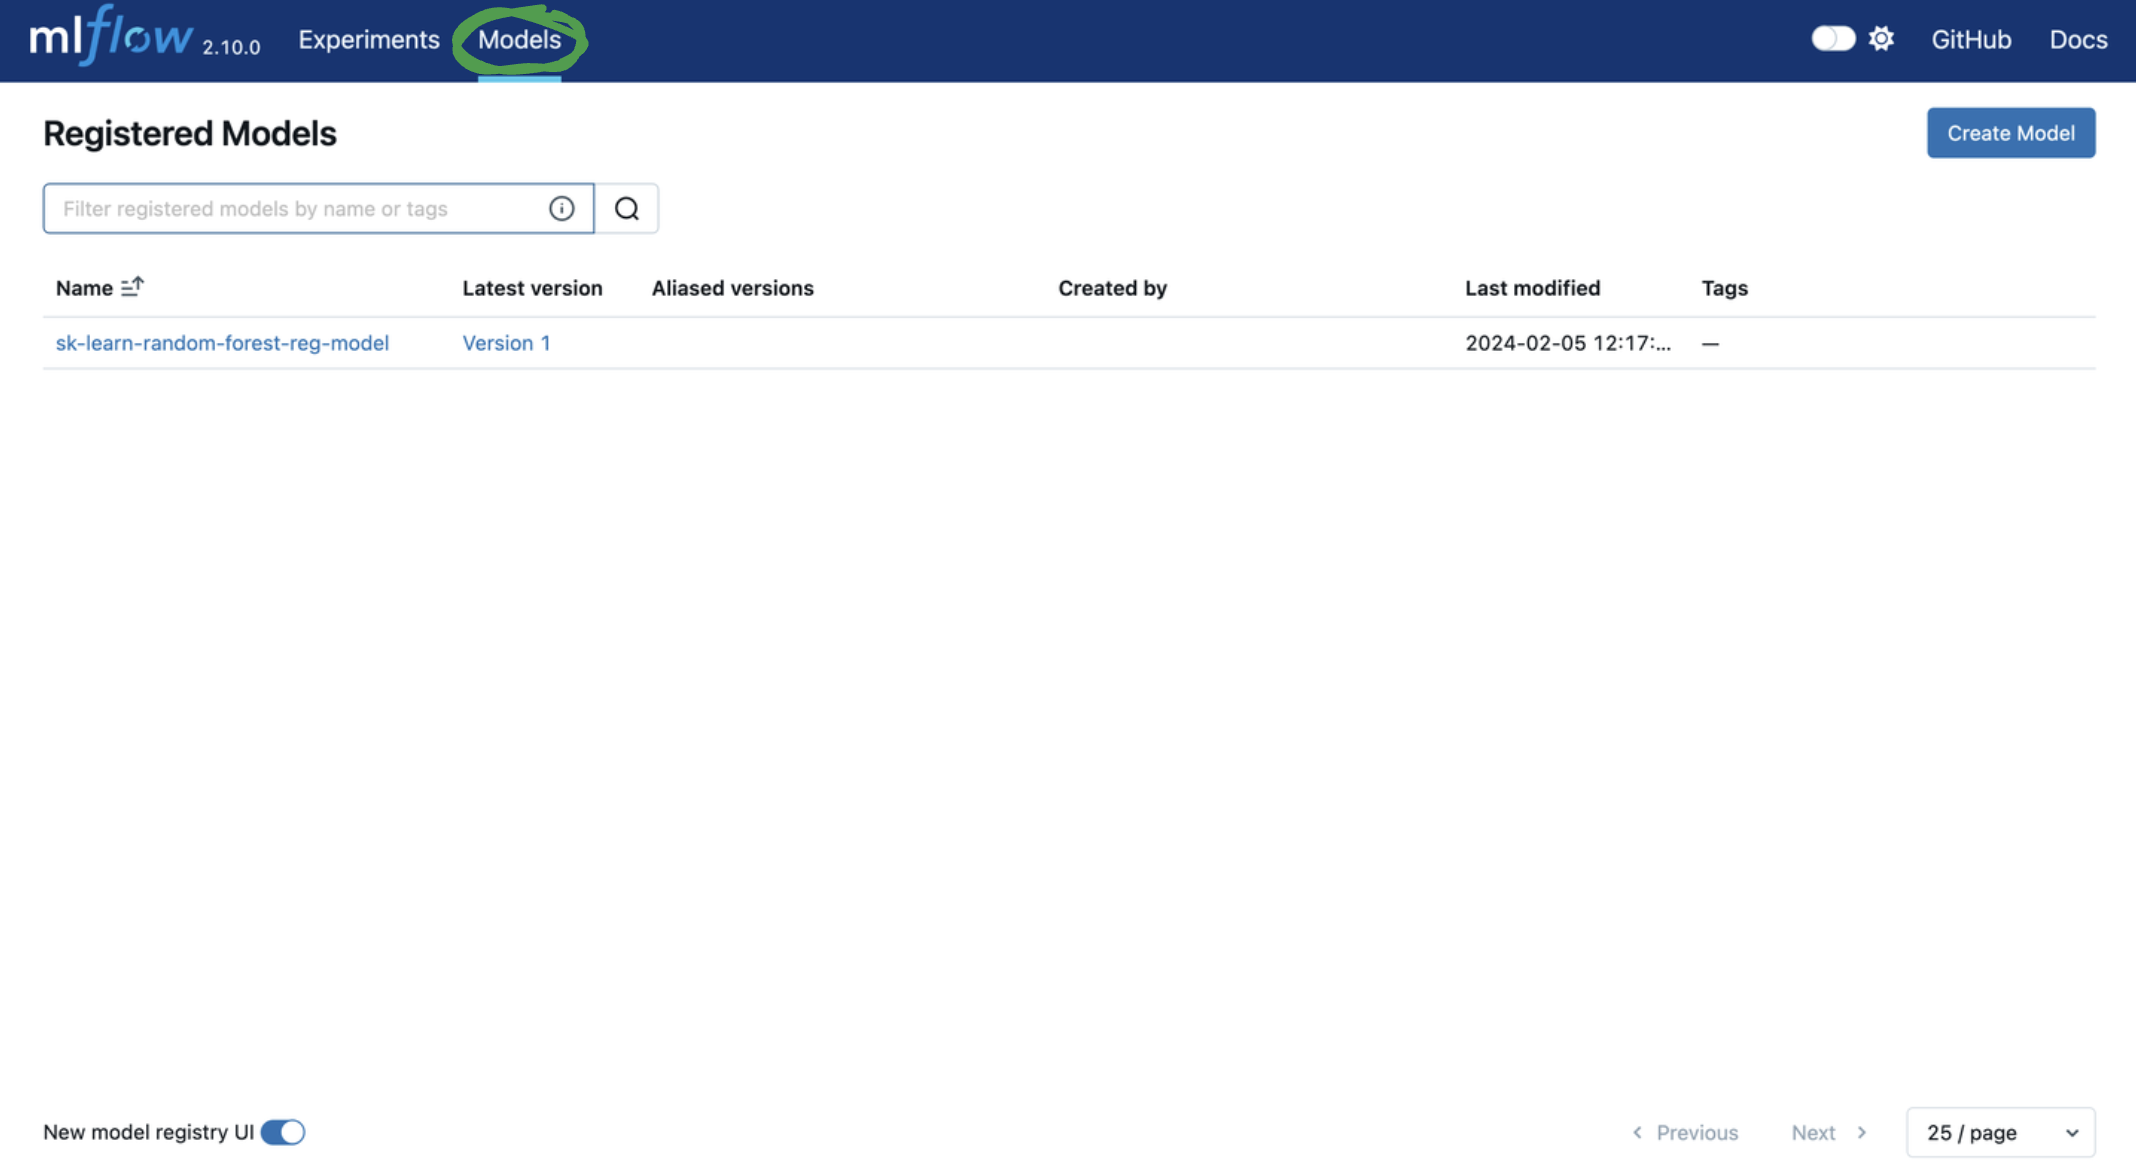

다음으로 모델 배포를 용이하게 하기 위해 태그와 모델 버전 별칭을 추가해 보겠습니다.   
모델 버전 표에서 해당 추가 링크 또는 연필 아이콘을 클릭하여 태그 및 별칭을 추가하거나 편집할 수 있습니다.   

1. key는 problem_type 으로 value는 regression 으로 모델 버전 태그를 추가합니다.

2. 모델 버전 별칭을 the_best_model_ever 로 추가합니다.
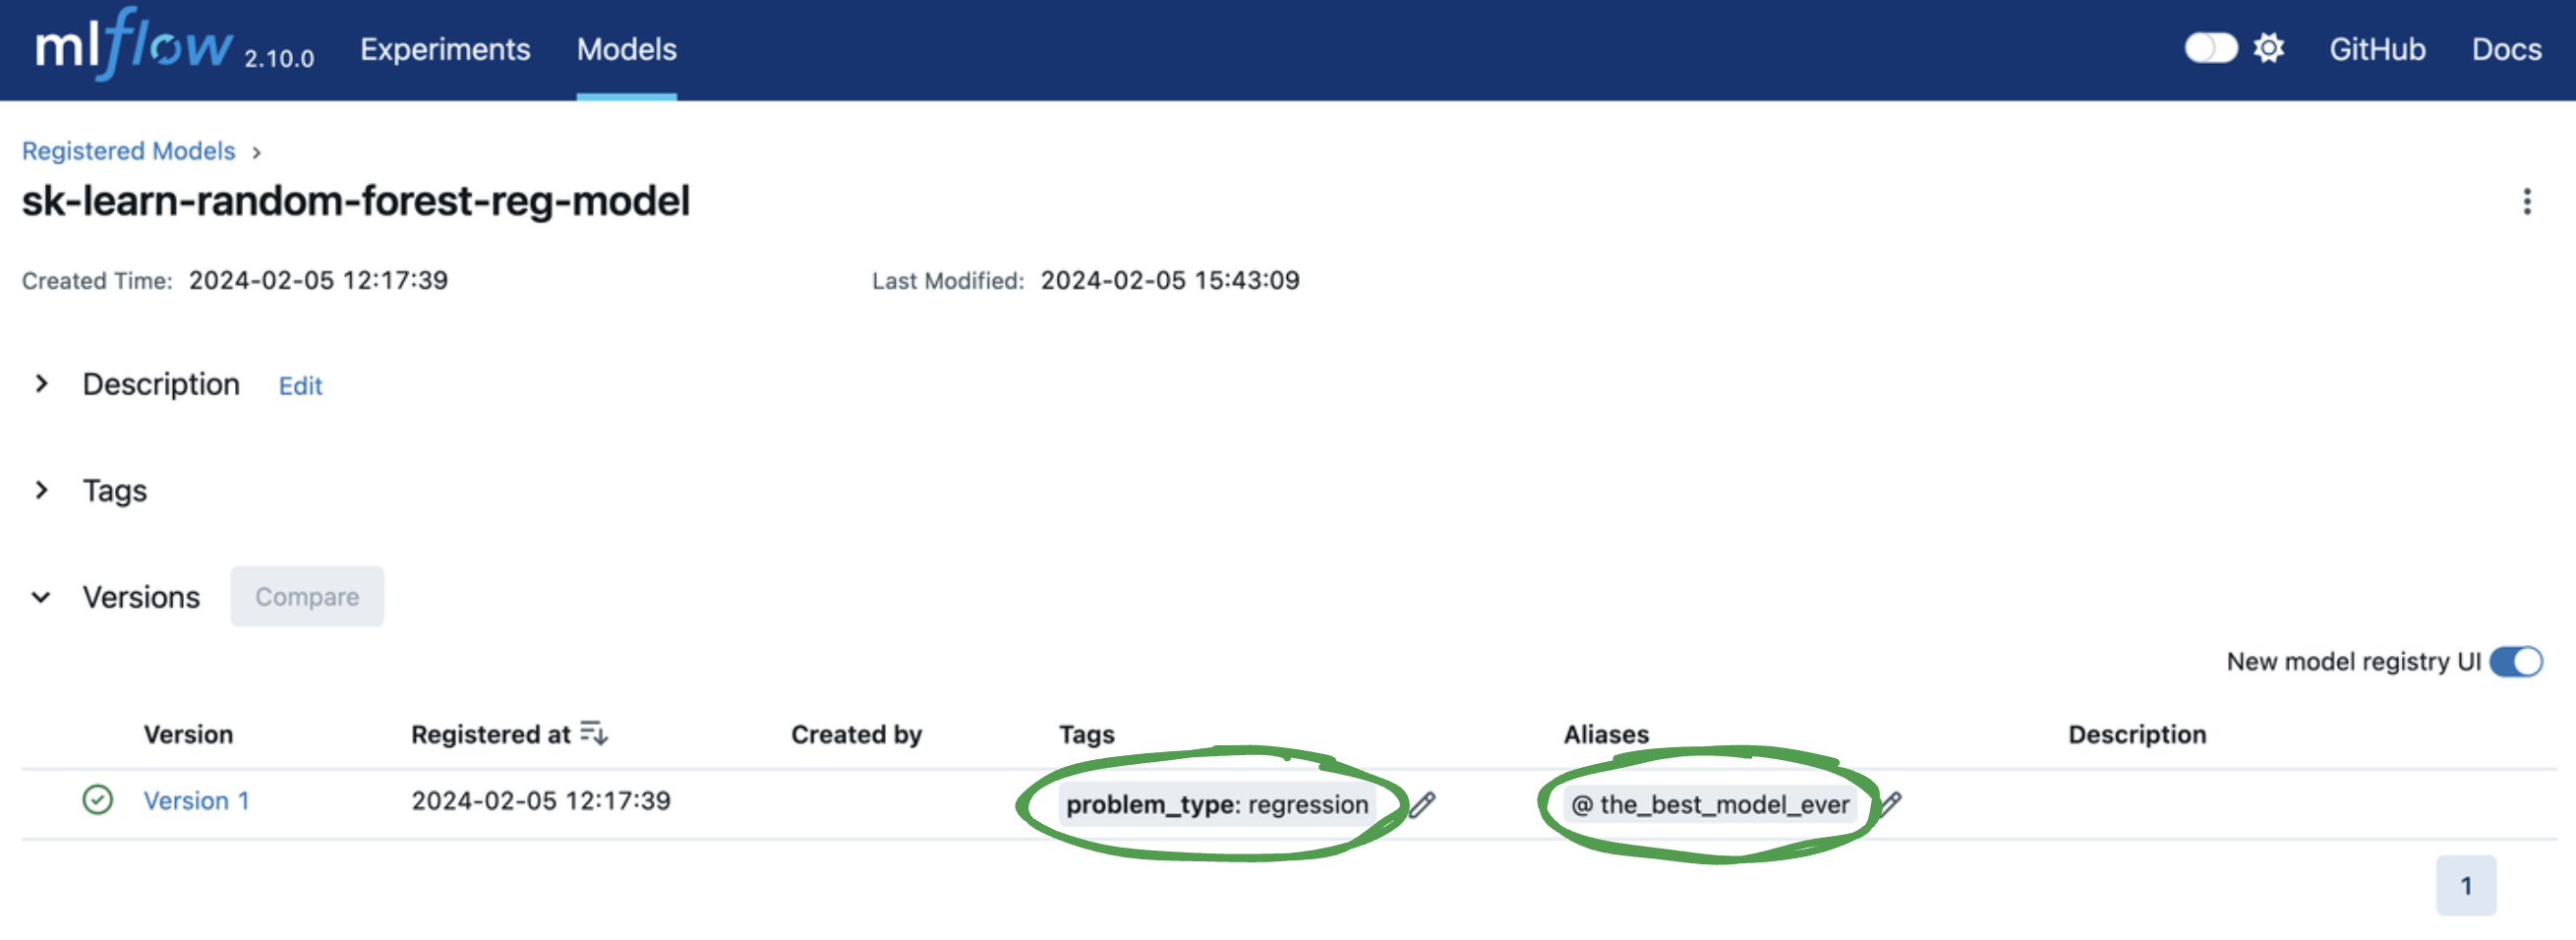

### 등록된 모델 로드
등록된 모델 버전에 대해 추론을 수행하려면 해당 모델을 메모리에 로드해야 합니다.    
모델 버전을 찾는 방법은 여러 가지가 있지만, 사용 가능한 정보에 따라 가장 좋은 방법은 달라집니다.    
아래 코드는 특정 모델 URI를 통해, 모델 레지스트리에서 모델을 로드하고 추론을 수행하는 가장 간단한 방법을 보여줍니다.

In [5]:
import mlflow.sklearn
from sklearn.datasets import make_regression

model_name = "sk-learn-random-forest-reg-model"
model_version = "latest"

# Load the model from the Model Registry
model_uri = f"models:/{model_name}/{model_version}"
model = mlflow.sklearn.load_model(model_uri)

# Generate a new dataset for prediction and predict
X_new, _ = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
y_pred_new = model.predict(X_new)

print(y_pred_new)

[ 16.36355607 -20.09258424   8.0136586    6.16919118  -1.81185423
   4.03116362 -24.95801449  68.78053495 -45.0766513   64.44760141
 -40.16931792 -25.54191065 -14.39985794 -38.0567874    8.05358765
 -25.73029816 -15.91990041 -10.99985266 -24.2475118  -32.70582446
  17.34781751  68.49980732  44.5541425   41.31593646  48.16602726
 -23.62019943  47.15590018  69.12741949  48.16602726  -0.26024544
 -28.49126919 -10.99985266  10.73067585 -10.61092056  -4.7324722
   2.76556278  58.93099448 -31.19567455 -35.55773052 -23.99366895
  48.16602726  13.34984948  12.56552213 -18.66808469 -32.70582446
 -39.30386685 -34.29680647  48.44675489 -33.40149961  20.35083862
 -15.0214084  -34.55064932  -2.28963784 -19.61227378   7.6979477
 -25.86538741 -11.95702358 -15.36598686   5.88539811 -30.23881739
 -25.47645531 -43.61170248 -43.7442754  -14.59055495 -40.16931792
 -32.70582446  -2.68114572  -5.39418041  16.15991316  -2.28963784
  41.662821    10.04512765  51.22797543 -23.09874036  10.04512765
  46.5774364

d:\강의자료\MLflow\py311\lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


sklearn을 사용하지 않는 경우, model flavor가 지원되는 경우,   
특정 model flavor 로드 메서드를 사용해야 합니다. 예: `mlflow.<flavor>.load_model()`    
model flavor가 지원되지 않는 경우 `mlflow.pyfunc.load_model()`을 활용해야 합니다.    
이 튜토리얼에서는 데모 목적으로 sklearn을 활용합니다.


### 예제 0: 추적 서버를 통한 로드
모델 URI는 직렬화된 모델의 고유 식별자입니다.    
모델 아티팩트가 tracking 서버에 experiments와 함께 저장되어 있는 경우,  
아래 모델 URI를 사용하여 모델 레지스트리를 우회하여 아티팩트를 메모리로 로드할 수 있습니다.

1. 절대 경로: `mlflow.sklearn.load_model("/Users/me/path/to/local/model")`
2. 상대 경로: `mlflow.sklearn.load_model("relative/path/to/local/model")`
3. Run  ID  : `mlflow.sklearn.load_model(f"runs:/{mlflow_run_id}/{run_relative_path_to_model}")`

그러나, 모델을 로깅한 환경과 동일한 환경이 아니라면 일반적으로 위의 정보를 얻을 수 없습니다.   
대신 모델의 이름과 버전을 활용하여 모델을 로드해야 합니다.

### 예제 1: 이름 및 버전을 통한 로드
model_name으로 모델을 메모리에 로드하려면 아래 방법을 사용합니다. 

`model = mlflow.sklearn.load_model(f"models:/{model_name}/{model_version}")  `

이 방법은 빠르고 쉽지만, 단조롭게 증가하는 모델 버전은 유연성이 부족합니다.    
모델 버전의 별칭을 활용하는 것이 더 효율적인 경우가 많습니다.

### 예제 2: 모델 버전 별칭을 통한 로드

모델 버전 별칭은 모델 버전에 대한 사용자 정의 식별자입니다.   
모델 등록 후 변경할 수 있으므로 모델 버전을 사용하는 코드에서 모델 버전을 분리합니다.  
    
예를 들어, 프로덕션 모델에 해당하는 production_model이라는 모델 버전 별칭이 있다고 가정해 보겠습니다.  
우리 팀이 배포할 준비가 된 더 나은 모델을 빌드할 때, 서비스 워크로드 코드를 변경할 필요가 없습니다.    
대신 MLflow에서 이전 모델 버전에서 새 모델 버전으로 production_model 별칭을 재할당하면 됩니다.    
이 작업은 UI에서 간단히 수행할 수 있습니다.    
API에서 동일한 모델 이름, 별칭 이름, 새 모델 버전 ID로 client.set_registered_model_alias를 실행하면 됩니다. 
    
이전 페이지에서 모델에 모델 버전 별칭을 추가했지만, 여기에는 프로그래밍 방식의 예가 있습니다.

In [6]:
import mlflow.sklearn
from mlflow import MlflowClient

client = MlflowClient()

# Set model version alias
model_name = "sk-learn-random-forest-reg-model"
model_version_alias = "the_best_model_ever"
client.set_registered_model_alias(
    model_name, model_version_alias, 1
)  # Duplicate of step in UI

# Get informawtion about the model
model_info = client.get_model_version_by_alias(model_name, model_version_alias)
model_tags = model_info.tags
print(model_tags)

# Get the model version using a model URI
model_uri = f"models:/{model_name}@{model_version_alias}"
model = mlflow.sklearn.load_model(model_uri)

print(model)

{'problem_type': 'regression'}
RandomForestRegressor(max_depth=2, random_state=42)


출력    
{'problem_type': 'regression'}  
RandomForestRegressor(max_depth=2, random_state=42)

모델 버전 별칭은 매우 동적이며 팀에 의미 있는 모든 것에 대응할 수 있습니다.   
가장 일반적인 예는 배포 상태입니다.   
예를 들어, 프로덕션에 챔피언 모델이 있지만 프로덕션 모델보다 성능이 더 뛰어난 챌린저 모델을 개발 중이라고 가정해 보겠습니다.    
챔피언 및 챌린저 모델 버전 별칭을 사용하여 이러한 모델 버전을 고유하게 식별하여 쉽게 액세스할 수 있습니다.  


이제 아래 작업을 편하게 하실 수 있을 것입니다.
- 모델 등록하기
- MLflow UI를 통해 모델 찾기 및 태그와 모델 버전 별칭 수정하기
- 추론을 위해 등록된 모델 로드하기